In [1]:
import itertools
import time
import matplotlib.pyplot as plt
import random

In [2]:
def is_satisfied(formula, assignment):
    for clause in formula:
        clause_satisfied = False
        for literal in clause:
            var = abs(literal)
            val = assignment[var]
            if (literal > 0 and val) or (literal < 0 and not val):
                clause_satisfied = True
                break
        if not clause_satisfied:
            return False
    return True

In [3]:
def naive_solve(formula):
    variables = sorted(list(set(abs(lit) for clause in formula for lit in clause)))
    n = len(variables)
    
    for values in itertools.product([True, False], repeat=n):
        assignment = dict(zip(variables, values))
        if is_satisfied(formula, assignment):
            return "SATISFIABLE", assignment
            
    return "UNSATISFIABLE", None

In [4]:
# --- Test Formulae ---

# SAT - easy
f_sat_05 = [[1, 2], [-1, 3], [-2, -3], [4, 5]]

# UNSAT - easy
f_unsat_05 = [[1], [-1], [2], [3], [4], [5]]

# SAT - easy 10 vars
f_sat_10 = [[i, i+1] for i in range(1, 10)]

# UNSAT - 10 vars, must check all 1,024 assignments
f_unsat_10 = [[i] for i in range(1, 11)] + [[-i] for i in range(1, 11)]

# SAT - 15 vars
f_sat_15 = [[i, -i+1] for i in range(1, 15)]

# UNSAT - 15 vars, must check all 32,768 assignments
f_unsat_15 = [[i] for i in range(1, 16)] + [[-i] for i in range(1, 16)]

# UNSAT - 20 vars, must check all 1,048,576 assignments
f_unsat_20 = [[i] for i in range(1, 21)] + [[-i] for i in range(1, 21)]

In [5]:
test_suite = [
    ("5-Var SAT", f_sat_05),
    ("5-Var UNSAT", f_unsat_05),
    ("10-Var SAT", f_sat_10),
    ("10-Var UNSAT", f_unsat_10),
    ("15-Var SAT", f_sat_15),
    ("15-Var UNSAT", f_unsat_15),
    ("20-Var UNSAT", f_unsat_20)
]

In [6]:
print(f"{'Formula':<15} | {'Result':<15} | {'Time (s)':<12} | {'Assignment'}")
print("-" * 80)

for name, formula in test_suite:
    start_time = time.perf_counter()
    result, assignment = naive_solve(formula)
    end_time = time.perf_counter()
    duration = end_time - start_time
    assign_str = str(assignment) if assignment else "None"
    print(f"{name:<15} | {result:<15} | {duration:.6f}s | {assign_str}")

Formula         | Result          | Time (s)     | Assignment
--------------------------------------------------------------------------------
5-Var SAT       | SATISFIABLE     | 0.000087s | {1: True, 2: False, 3: True, 4: True, 5: True}
5-Var UNSAT     | UNSATISFIABLE   | 0.000132s | None
10-Var SAT      | SATISFIABLE     | 0.000029s | {1: True, 2: True, 3: True, 4: True, 5: True, 6: True, 7: True, 8: True, 9: True, 10: True}
10-Var UNSAT    | UNSATISFIABLE   | 0.004960s | None
15-Var SAT      | SATISFIABLE     | 0.000056s | {0: True, 1: True, 2: True, 3: True, 4: True, 5: True, 6: True, 7: True, 8: True, 9: True, 10: True, 11: True, 12: True, 13: True, 14: True}
15-Var UNSAT    | UNSATISFIABLE   | 0.154851s | None
20-Var UNSAT    | UNSATISFIABLE   | 5.130855s | None


In [7]:
def run_scalability_test(start_n, end_n):
    n_vars = []
    times = []
    
    print(f"{'Variables (n)':<15} | {'Assignments':<15} | {'Time (s)':<15} | {'Status'}")
    print("-" * 65)
    
    for n in range(start_n, end_n + 1):
        # Create an UNSAT formula for exactly n variables
        # Format: [[1], [-1], [2], [-2] ... [n], [-n]]
        formula = []
        for i in range(1, n + 1):
            formula.append([i])
            formula.append([-i])
            
        start_time = time.perf_counter()
        status, _ = naive_solve(formula)
        end_time = time.perf_counter()
        
        duration = end_time - start_time
        
        n_vars.append(n)
        times.append(duration)
        
        print(f"{n:<15} | {2**n:<15,} | {duration:.6f}s | {status}")
        
    return n_vars, times

In [ ]:
n_vars, times = run_scalability_test(10, 24)

Variables (n)   | Assignments     | Time (s)        | Status
-----------------------------------------------------------------
10              | 1,024           | 0.002643s | UNSATISFIABLE
11              | 2,048           | 0.006999s | UNSATISFIABLE
12              | 4,096           | 0.015760s | UNSATISFIABLE
13              | 8,192           | 0.032423s | UNSATISFIABLE
14              | 16,384          | 0.064460s | UNSATISFIABLE
15              | 32,768          | 0.107438s | UNSATISFIABLE
16              | 65,536          | 0.275188s | UNSATISFIABLE
17              | 131,072         | 0.517010s | UNSATISFIABLE
18              | 262,144         | 0.983717s | UNSATISFIABLE
19              | 524,288         | 2.405393s | UNSATISFIABLE
20              | 1,048,576       | 5.927668s | UNSATISFIABLE
21              | 2,097,152       | 12.459589s | UNSATISFIABLE
22              | 4,194,304       | 27.047049s | UNSATISFIABLE
23              | 8,388,608       | 55.315626s | UNSATISFIABLE


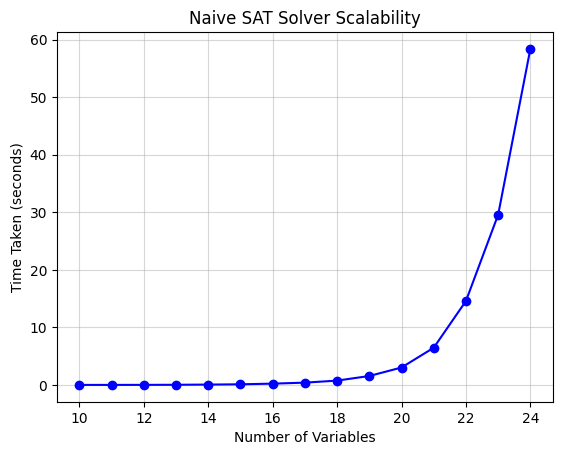

In [59]:
plt.plot(n_vars, times, marker='o', linestyle='-', color='b')

plt.title('Naive SAT Solver Scalability')
plt.xlabel('Number of Variables')
plt.ylabel('Time Taken (seconds)')
plt.grid(True, which="both", ls="-", alpha=0.5)

In [60]:
def simplify(delta, literal):
    delta_prime = []
    p_alpha = literal
    p_beta = -literal 

    for clause in delta:
        if p_alpha in clause:
            continue
        elif p_beta in clause:
            new_clause = [lit for lit in clause if lit != p_beta]
            delta_prime.append(new_clause)
        else:
            delta_prime.append(clause)
            
    return delta_prime

In [61]:
def dpll(delta, phi):
    delta_prime = [list(c) for c in delta]  
    phi_prime = phi.copy()                 

    # 1. Unit Propagation
    while True:
        unit_clauses = [c for c in delta_prime if len(c) == 1]
        if not unit_clauses:
            break
        
        # Take the first unit clause found
        p_alpha = unit_clauses[0][0]
        var = abs(p_alpha)
        val = True if p_alpha > 0 else False
        
        phi_prime[var] = val
        delta_prime = simplify(delta_prime, p_alpha)

    # 2. Termination Tests
    # Check for empty clause (contradiction)
    if any(len(c) == 0 for c in delta_prime):
        return "unsatisfiable"
    
    # Check if clause set is empty (success)
    if not delta_prime:
        return phi_prime

    # 3. Splitting Rule
    # Select unassigned variable (just taking the first one available)
    all_vars = {abs(lit) for clause in delta_prime for lit in clause}
    p = sorted(list(all_vars))[0]

    # Branch 1: Assume p is True
    res = dpll(simplify(delta_prime, p), {**phi_prime, p: True})
    if res != "unsatisfiable":
        return res

    # Branch 2: Assume p is False (F)
    return dpll(simplify(delta_prime, -p), {**phi_prime, p: False})

In [62]:
# Testing the same fomrulae
print(f"{'Formula':<15} | {'Result':<15} | {'Time (s)':<12} | {'Assignment'}")
print("-" * 80)

for name, formula in test_suite:
    start_time = time.perf_counter()
    
    result_data = dpll(formula, {})
    
    end_time = time.perf_counter()
    duration = end_time - start_time
    
    if isinstance(result_data, dict):
        result_status = "SATISFIABLE"
        assign_str = str(result_data)
    else:
        result_status = "UNSATISFIABLE"
        assign_str = "None"
        
    print(f"{name:<15} | {result_status:<15} | {duration:.6f}s | {assign_str}")

Formula         | Result          | Time (s)     | Assignment
--------------------------------------------------------------------------------
5-Var SAT       | SATISFIABLE     | 0.000053s | {1: True, 3: True, 2: False, 4: True}
5-Var UNSAT     | UNSATISFIABLE   | 0.000028s | None
10-Var SAT      | SATISFIABLE     | 0.000123s | {1: True, 2: True, 3: True, 4: True, 5: True, 6: True, 7: True, 8: True, 9: True}
10-Var UNSAT    | UNSATISFIABLE   | 0.000101s | None
15-Var SAT      | SATISFIABLE     | 0.000122s | {0: True, 1: True, 2: True, 3: True, 4: True, 5: True, 6: True, 7: True, 8: True, 9: True, 10: True, 11: True, 12: True, 13: True, 14: True}
15-Var UNSAT    | UNSATISFIABLE   | 0.000211s | None
20-Var UNSAT    | UNSATISFIABLE   | 0.000308s | None


In [63]:
def run_scalability_test_dpll(start_n, end_n):
    n_vars = []
    dpll_times = []
    
    print(f"{'n':<5} | {'DPLL Time (s)':<15} | {'Status'}")
    print("-" * 35)
    
    for n in range(start_n, end_n + 1):
        formula = []
        for i in range(1, n + 1):
            formula.append([i])
            formula.append([-i])
            
        start_time = time.perf_counter()
        result = dpll(formula, {})
        end_time = time.perf_counter()
        
        dpll_time = end_time - start_time
        status = "UNSAT" if result == "unsatisfiable" else "SAT"
        
        n_vars.append(n)
        dpll_times.append(dpll_time)
        
        print(f"{n:<5} | {dpll_time:.6f} | {status}")
        
    return n_vars, dpll_times

In [64]:
n_vars, dpll_times = run_scalability_test_dpll(10, 24)

n     | DPLL Time (s)   | Status
-----------------------------------
10    | 0.000111 | UNSAT
11    | 0.000111 | UNSAT
12    | 0.000123 | UNSAT
13    | 0.000138 | UNSAT
14    | 0.000156 | UNSAT
15    | 0.000170 | UNSAT
16    | 0.000191 | UNSAT
17    | 0.000236 | UNSAT
18    | 0.000235 | UNSAT
19    | 0.000257 | UNSAT
20    | 0.000282 | UNSAT
21    | 0.000313 | UNSAT
22    | 0.000337 | UNSAT
23    | 0.000354 | UNSAT
24    | 0.000384 | UNSAT


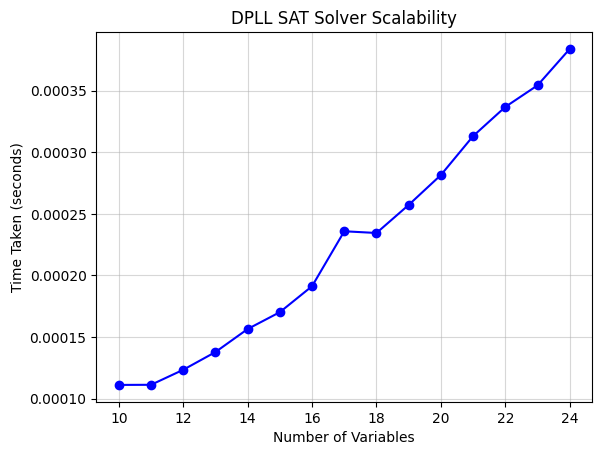

In [65]:
plt.plot(n_vars, dpll_times, marker='o', linestyle='-', color='b')

plt.title('DPLL SAT Solver Scalability')
plt.xlabel('Number of Variables')
plt.ylabel('Time Taken (seconds)')
plt.grid(True, which="both", ls="-", alpha=0.5)

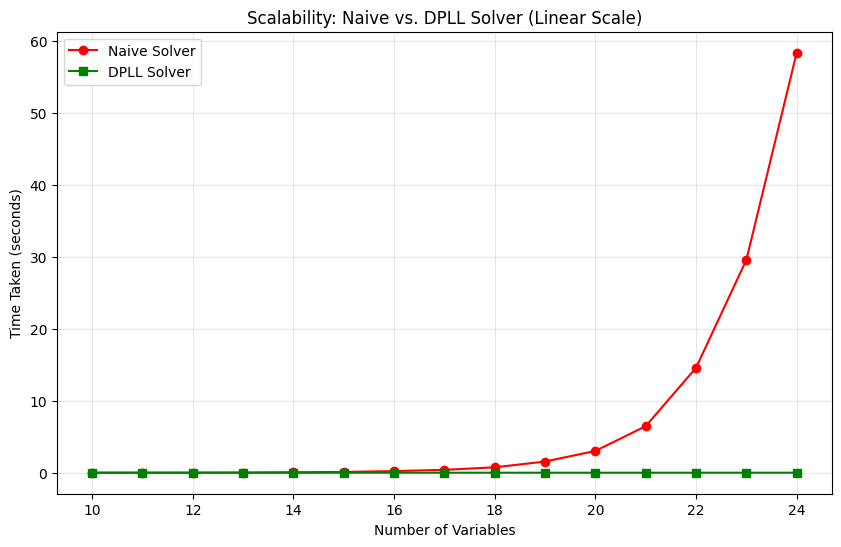

In [66]:
plt.figure(figsize=(10, 6))

plt.plot(n_vars, times, marker='o', color='red', label='Naive Solver')
plt.plot(n_vars, dpll_times, marker='s', color='green', label='DPLL Solver')

plt.title('Scalability: Naive vs. DPLL Solver (Linear Scale)')
plt.xlabel('Number of Variables')
plt.ylabel('Time Taken (seconds)')
plt.grid(True, ls="-", alpha=0.3)
plt.legend()

plt.show()

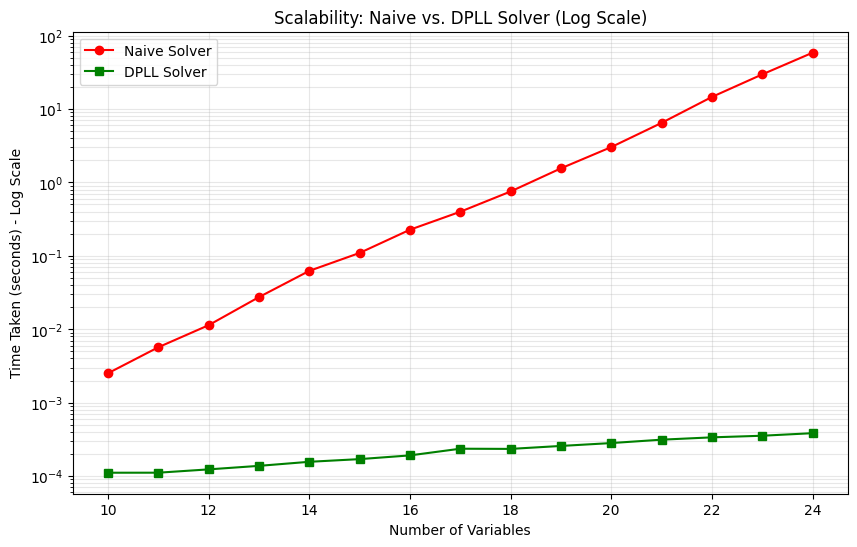

In [67]:
plt.figure(figsize=(10, 6))

plt.plot(n_vars, times, marker='o', color='red', label='Naive Solver')
plt.plot(n_vars, dpll_times, marker='s', color='green', label='DPLL Solver')

plt.yscale('log')

plt.title('Scalability: Naive vs. DPLL Solver (Log Scale)')
plt.xlabel('Number of Variables')
plt.ylabel('Time Taken (seconds) - Log Scale')
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()

plt.show()